<a href="https://colab.research.google.com/github/pachterlab/GRNP_2020/blob/master/notebooks/figure_generation/GenFig4AC_S23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generates figure 4 A-C and supplementary figure 23**

This notebook generates figures for showing the improvement of BUTTERFLY correction on scRNA-Seq data, by comparing a downsampled and full dataset. Furthermore, we show the effect of "borrowing" CU histogram information from similar datasets, and determine the sampling noise, which sets a theoretical maximum performance for the prediction in downsampling scenarios such as this.

Steps:
1. Download the code and processed data
2. Setup the R environment
3. Generate the figures

The data for these figures is produced by the following notebooks:

Processing of FASTQ files with kallisto and bustools:

https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/FASTQ_processing/ProcessPBMC_V3_3.ipynb

Preprocessing of BUG files:

https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/R_processing/ProcessR_PBMC_V3_3.ipynb

Precalculation of figure data: 

https://github.com/pachterlab/GRNP_2020/blob/master/notebooks/figure_generation/GenFig4AC_S23Data.ipynb


**1. Download the code and processed data**

In [1]:
#download the R code
![ -d "GRNP_2020" ] && rm -r GRNP_2020

!git clone https://github.com/pachterlab/GRNP_2020.git


Cloning into 'GRNP_2020'...
remote: Enumerating objects: 2149, done.
remote: Counting objects: 100% (431/431), done.
remote: Compressing objects: 100% (361/361), done.
remote: Total 2149 (delta 321), reused 104 (delta 70), pack-reused 1718
Receiving objects: 100% (2149/2149), 11.43 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (1506/1506), done.


In [2]:
#download processed data from Zenodo for all datasets
![ -d "figureData" ] && rm -r figureData
!mkdir figureData
!cd figureData && wget https://zenodo.org/record/4661263/files/FigureData.zip?download=1 && unzip 'FigureData.zip?download=1' && rm 'FigureData.zip?download=1'


--2021-05-18 11:54:17--  https://zenodo.org/record/4661263/files/FigureData.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7490400 (7.1M) [application/octet-stream]
Saving to: ‘FigureData.zip?download=1’

FigureData.zip?down 100%[===================>]   7.14M  4.99MB/s    in 1.4s    

2021-05-18 11:54:20 (4.99 MB/s) - ‘FigureData.zip?download=1’ saved [7490400/7490400]

Archive:  FigureData.zip?download=1
 extracting: Fig3C_r1.RDS            
 extracting: Fig3C_r2.RDS            
 extracting: Fig3_h1.RDS             
 extracting: Fig3_h2.RDS             
  inflating: Fig4AC_ldata.RDS        
  inflating: Fig4AC_ldata2.RDS       
  inflating: Fig4_DE.RDS             
  inflating: gc.RDS                  
  inflating: simDepthData.RDS        
  inflating: simFcData.RDS           
  inflating: simGexData.RDS          
 extracting: simMuData.RDS  

In [3]:
#Check that download worked
!cd figureData && ls -l && cd PBMC_V3_3 && ls -l

total 7940
-rw-r--r-- 1 root root     239 Jun 30  2020 Fig3C_r1.RDS
-rw-r--r-- 1 root root     233 Jun 30  2020 Fig3C_r2.RDS
-rw-r--r-- 1 root root     683 Jun 30  2020 Fig3_h1.RDS
-rw-r--r-- 1 root root     830 Jun 30  2020 Fig3_h2.RDS
-rw-r--r-- 1 root root  372141 Apr  3 16:59 Fig4AC_ldata2.RDS
-rw-r--r-- 1 root root  480126 Apr  3 16:59 Fig4AC_ldata.RDS
-rw-r--r-- 1 root root 3949960 Feb 25 18:38 Fig4_DE.RDS
-rw-r--r-- 1 root root  304548 Feb 26 13:30 gc.RDS
-rw-r--r-- 1 root root 1128027 Feb 15 11:34 simDepthData.RDS
-rw-r--r-- 1 root root  621646 Feb 15 13:22 simFcData.RDS
-rw-r--r-- 1 root root 1237109 Feb 15 15:46 simGexData.RDS
-rw-r--r-- 1 root root     284 Feb 15 01:28 simMuData.RDS
/bin/bash: line 0: cd: PBMC_V3_3: No such file or directory


**2. Prepare the R environment**

In [4]:
#switch to R mode
%reload_ext rpy2.ipython


In [5]:
#install the R packages and setup paths
%%R
install.packages("dplyr")
install.packages("ggplot2")
install.packages("DescTools")
install.packages("ggpubr")
install.packages("hexbin")
install.packages("reshape2")
install.packages("farver")




R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/dplyr_1.0.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 954401 bytes (932 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

**3. Generate the figures**


In [6]:
#First set some path variables
%%R
source("GRNP_2020/RCode/pathsGoogleColab.R")


In [7]:
#Import the code for prediction (available in other notebooks)
%%R
source(paste0(sourcePath,"ButterflyHelpers.R"))
#source(paste0(sourcePath,"preseqHelpers.R"))
source(paste0(sourcePath,"CCCHelpers.R"))
source(paste0(sourcePath,"ggplotHelpers.R"))





R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
#create figure directory
![ -d "figures" ] && rm -r figures
!mkdir figures

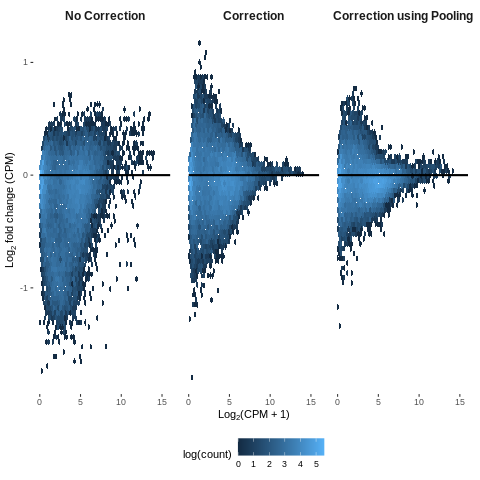

In [9]:
#Create and save the figures
%%R
library(ggplot2)
library(ggpubr)
library(hexbin)
library(dplyr)


ldata = readRDS(paste0(figure_data_path, "Fig4AC_ldata.RDS"))
ldata2 = readRDS(paste0(figure_data_path, "Fig4AC_ldata2.RDS"))

#generate plot data
plotdata = tibble(gene=ldata$gene, 
                  x=ldata$x, 
                  nopred=ldata$nopred - ldata$trueval,
                  pred=ldata$pred - ldata$trueval,
                  poolpred=ldata$poolpred - ldata$trueval)

#melt
plotdata.m = reshape2::melt(plotdata, id.vars=c("gene","x"), measure.vars = c("nopred", "pred", "poolpred"))

labl = labeller(variable = 
                      c("nopred" = "No Correction",
                        "pred" = "Correction",
                        "poolpred" = "Correction using Pooling"))

dfline = data.frame(x=c(0,16), y=c(0,0))

dummyData = data.frame(x=c(0,0), y=c(1.1, -1.5)) #used in a trick to set y axis range below

fig4AC = ggplot(plotdata.m) +
  stat_binhex(bins=60,na.rm = TRUE, mapping=aes(x = x, y=value, fill = log(..count..))) + # opts(aspect.ratio = 1) +
  facet_wrap(facets = ~  variable, scales = "free_x", labeller = labl, ncol=3) +
  geom_line(data=dfline, mapping = aes(x=x, y=y), color="black", size=1) + 
  geom_blank(data = dummyData, mapping = aes(x=x, y=y)) + #trick to set y axis range
  labs(y=expression(Log[2]*" fold change (CPM)"), x=expression(Log[2]*"(CPM + 1)")) +
  theme(panel.background = element_rect("white", "white", 0, 0, "white"),
        legend.position= "bottom", legend.direction = "horizontal",#, legend.title = element_blank())
        strip.text.x = element_text(size = 12, face = "bold"),
        #legend.position= "none",
        strip.background = element_blank())

print(fig4AC)

ggsave(
  paste0(figure_path, "Fig4AC.png"),
  plot = fig4AC, device = "png",
  width = 7, height = 4, dpi = 300)



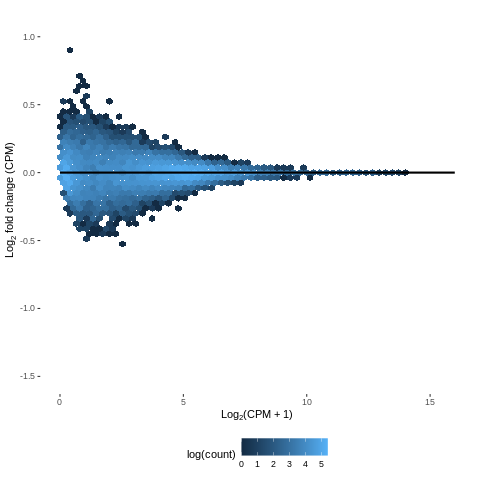

In [10]:
%%R
#########################
# Fig S23 (Sampling noise)
#########################
#cpm and log transform

plotdata2 = tibble(gene=ldata2$gene, 
                  x=ldata2$x, 
                  y=ldata2$sampling - ldata$nopred)


dfline = data.frame(x=c(0,16), y=c(0,0))
dummyData = data.frame(x=c(0,0), y=c(1.1, -1.5))

figS23 = ggplot(plotdata2) +
  stat_binhex(bins=60,na.rm = TRUE, mapping=aes(x = x, y=y, fill = log(..count..))) + # opts(aspect.ratio = 1) +
  #facet_wrap(facets = ~  variable, scales = "free_x", labeller = labl, ncol=3) +
  geom_line(data=dfline, mapping = aes(x=x, y=y), color="black", size=1) + 
  geom_blank(data = dummyData, mapping = aes(x=x, y=y)) + #trick to set y axis range
  labs(y=expression(Log[2]*" fold change (CPM)"), x=expression(Log[2]*"(CPM + 1)")) +
  theme(panel.background = element_rect("white", "white", 0, 0, "white"),
        legend.position= "bottom", legend.direction = "horizontal",#, legend.title = element_blank())
        strip.text.x = element_text(size = 12, face = "bold"),
        #legend.position= "none",
        strip.background = element_blank())

print(figS23)


ggsave(
  paste0(figure_path, "FigS23.png"),
  plot = figS23, device = "png",
  width = 3, height = 4, dpi = 300)



In [11]:
#The data to present over the plots
%%R
print(paste0("CCC, no pred: ", getCCC(ldata$nopred, ldata$trueval))) #0.981275291888894
print(paste0("CCC, pred no pooling: ", getCCC(ldata$pred, ldata$trueval))) #0.993829998877551
print(paste0("CCC, pred with pooling: ", getCCC(ldata$poolpred, ldata$trueval))) #0.997030743452436
print(paste0("CCC, no pred, bin ds vs ds: ", getCCC(ldata2$nopred, ldata2$sampling))) #0.99895348369159

#also get mean squared error
print(paste0("MSE, no pred: ", getMSE(ldata$nopred, ldata$trueval))) #0.192957136231134
print(paste0("MSE, pred no pooling: ", getMSE(ldata$pred, ldata$trueval))) #0.0624471167682468
print(paste0("MSE, pred with pooling: ", getMSE(ldata$poolpred, ldata$trueval))) #0.0299541970779269
print(paste0("MSE, no pred, ds 100 times vs ds: ", getMSE(ldata2$nopred, ldata2$sampling))) #0.0108884743502623


[1] "CCC, no pred: 0.981275291888894"
[1] "CCC, pred no pooling: 0.993829998877551"
[1] "CCC, pred with pooling: 0.997030743452436"
[1] "CCC, no pred, bin ds vs ds: 0.99895348369159"
[1] "MSE, no pred: 0.192957136231134"
[1] "MSE, pred no pooling: 0.0624471167682468"
[1] "MSE, pred with pooling: 0.0299541970779269"
[1] "MSE, no pred, ds 100 times vs ds: 0.0108884743502623"
